In [1]:
from zoish.feature_selectors.zoish_feature_selector import ScallyShapFeatureSelector
import xgboost
from optuna.pruners import HyperbandPruner
from optuna.samplers._tpe.sampler import TPESampler
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score
    )
from zoish.utils.helper_funcs import catboost


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Example 1 :Computer Hardware Data Set (a regression problem)
  
https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
# column names
col_names=[
    "vendor name",
    "Model Name",
    "MYCT",
    "MMIN",
    "MMAX",
    "CACH",
    "CHMIN",
    "CHMAX",
    "PRP"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data

,vendor name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
adviser,32/60,125,256,6000,256,16,128,198,199
amdahl,470v/7,29,8000,32000,32,8,32,269,253
amdahl,470v/7a,29,8000,32000,32,8,32,220,253
amdahl,470v/7b,29,8000,32000,32,8,32,172,253
amdahl,470v/7c,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...
sperry,80/8,124,1000,8000,0,1,8,42,37
sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
sratus,32,125,2000,8000,0,2,14,52,41
wang,vs-100,480,512,8000,32,0,0,67,47


# Train test split

In [3]:
X = data.loc[:, data.columns != "PRP"]
y = data.loc[:, data.columns == "PRP"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, random_state=42)


# Find feature types for later use

In [4]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


#  Define Feature selector and set its arguments  

In [5]:



SFC_CATREG_OPTUNA = ScallyShapFeatureSelector(
        n_features=5,
        estimator=catboost.CatBoostRegressor(),
        estimator_params={
                  # desired lower bound and upper bound for depth
                  'depth'         : [6,10],
                  # desired lower bound and upper bound for depth
                  'learning_rate' : [0.05, 0.1],  
                    },
        hyper_parameter_optimization_method="optuna",
        shap_version="v0",
        measure_of_accuracy="r2",
        list_of_obligatory_features=[],
        test_size=0.33,
        cv=KFold(n_splits=3, random_state=42, shuffle=True),
        with_shap_summary_plot=True,
        with_stratified=False,
        verbose=0,
        random_state=42,
        n_jobs=-1,
        n_iter=100,
        eval_metric=None,
        number_of_trials=20,
        sampler=TPESampler(),
        pruner=HyperbandPruner(),
    )


Setting value for n_features
Setting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Getting value for estimator
Setting value for estimator_params
Setting value for hyper_parameter_optimization_method
Setting value for shap_version
Setting value for measure_of_accuracy
Setting value for list_of_obligatory_features
Setting value for test_size
Setting value for Cross Validation object
Setting value for with_shap_summary_plot
Setting value for with_stratified
Setting value for verbose
Setting value for random_state
Setting value for n_jobs
Setting value for n_iter
Setting value for eval_metric
Setting value for number_of_trials
Setting value for sampler
Setting value for pruner
Setting value for best_estimator
Setting value for importance_df


# Build sklearn Pipeline

In [6]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_CATREG_OPTUNA', SFC_CATREG_OPTUNA),
            # add any regression model from sklearn e.g., LinearRegression
            ('regression', LinearRegression())


 ])



# Run Pipeline

[I 2022-07-25 15:39:55,527] A new study created in memory with name: no-name-273fdb51-caa3-4cbc-8e16-9de19bfba4f0


Getting value for hyper_parameter_optimization_method
Getting value for hyper_parameter_optimization_method
Getting value for hyper_parameter_optimization_method
Getting value for estimator
Getting value for measure_of_accuracy
Getting value for estimator_params
Getting value for verbose
Getting value for test_size
Getting value for random_state
Getting value for eval_metric
Getting value for number_of_trials
Getting value for sampler
Getting value for pruner
Getting value for with_stratified


[I 2022-07-25 15:39:56,313] Trial 0 finished with value: 0.9758555625240125 and parameters: {'depth': 8, 'learning_rate': 0.07260410634993734}. Best is trial 0 with value: 0.9758555625240125.
[I 2022-07-25 15:39:56,718] Trial 1 finished with value: 0.9817384895368967 and parameters: {'depth': 6, 'learning_rate': 0.07350708299910892}. Best is trial 1 with value: 0.9817384895368967.
[I 2022-07-25 15:39:57,066] Trial 2 finished with value: 0.984629370338989 and parameters: {'depth': 6, 'learning_rate': 0.05179810046215049}. Best is trial 2 with value: 0.984629370338989.
[I 2022-07-25 15:39:57,520] Trial 3 finished with value: 0.9815265944849734 and parameters: {'depth': 7, 'learning_rate': 0.07262889493520348}. Best is trial 2 with value: 0.984629370338989.
[I 2022-07-25 15:39:58,330] Trial 4 finished with value: 0.9727876884494192 and parameters: {'depth': 9, 'learning_rate': 0.05451833732010939}. Best is trial 2 with value: 0.984629370338989.
[I 2022-07-25 15:39:58,724] Trial 5 finished

{'depth': 6, 'learning_rate': 0.05033522281569107}
0:	learn: 110.6821436	total: 414us	remaining: 414ms
1:	learn: 107.8002506	total: 774us	remaining: 386ms
2:	learn: 105.4255396	total: 1.18ms	remaining: 391ms
3:	learn: 102.4523139	total: 1.5ms	remaining: 373ms
4:	learn: 99.7189951	total: 1.74ms	remaining: 346ms
5:	learn: 97.5505904	total: 2.01ms	remaining: 333ms
6:	learn: 94.9993313	total: 2.43ms	remaining: 345ms
7:	learn: 92.4637168	total: 2.97ms	remaining: 368ms
8:	learn: 90.3252581	total: 3.32ms	remaining: 365ms
9:	learn: 87.9073506	total: 3.6ms	remaining: 356ms
10:	learn: 85.9702768	total: 3.86ms	remaining: 347ms
11:	learn: 83.9828420	total: 4.12ms	remaining: 339ms
12:	learn: 82.0033415	total: 4.36ms	remaining: 331ms
13:	learn: 79.9987699	total: 4.63ms	remaining: 326ms
14:	learn: 78.2156982	total: 4.95ms	remaining: 325ms
15:	learn: 76.3796361	total: 5.26ms	remaining: 324ms
16:	learn: 74.5267446	total: 5.57ms	remaining: 322ms
17:	learn: 72.8311840	total: 5.84ms	remaining: 319ms
18:	l

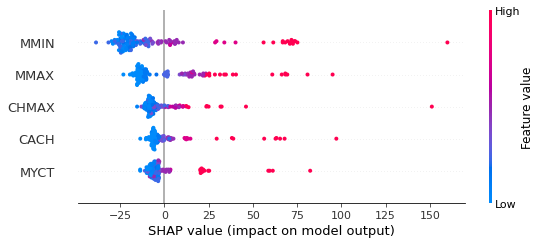

Getting value for estimator
Setting value for importance_df
Getting value for importance_df
             0          1
0  vendor name   1.476643
1   Model Name    8.23075
2         MYCT    8.64702
3         MMIN  23.794136
4         MMAX  17.150473
5         CACH   8.784303
6        CHMIN   5.332078
7        CHMAX   9.414419
Getting value for importance_df
Getting value for importance_df
   column_name shap_importance
0  vendor name        1.476643
1   Model Name         8.23075
2         MYCT         8.64702
3         MMIN       23.794136
4         MMAX       17.150473
5         CACH        8.784303
6        CHMIN        5.332078
7        CHMAX        9.414419
Getting value for importance_df
Setting value for importance_df
Getting value for importance_df
   column_name shap_importance
3         MMIN       23.794136
4         MMAX       17.150473
7        CHMAX        9.414419
5         CACH        8.784303
2         MYCT         8.64702
1   Model Name         8.23075
6        CHMIN    

In [7]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [8]:
print('r2 score : ')
print(r2_score(y_test,y_pred))


r2 score : 
0.919944073154186
